In [1]:
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Scaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import binarize

# Train Test Split
from sklearn.model_selection import train_test_split

#Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
#import xgboost as xgb

#Metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error

#Cross Validation
from sklearn.model_selection import GridSearchCV

#Pipeline
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Importamos nuestro Data Set
Trabajaremos con la estacion que registra mayor numero de viajes 

In [2]:
df = pd.read_csv('Desafio_4.csv')

In [3]:
df.shape

(8760, 10)

In [4]:
df.head()

,estación,fecha,año,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes
0,014 - Pacifico,2021-01-01 00:00:00,2021,1,1,4,0,0,2,1
1,014 - Pacifico,2021-01-01 01:00:00,2021,1,1,4,0,1,5,7
2,014 - Pacifico,2021-01-01 02:00:00,2021,1,1,4,0,2,7,2
3,014 - Pacifico,2021-01-01 03:00:00,2021,1,1,4,0,3,2,1
4,014 - Pacifico,2021-01-01 04:00:00,2021,1,1,4,0,4,2,2


In [5]:
df.fecha = pd.to_datetime(df['fecha'])

In [6]:
días = { 0 : 'lunes', 1 : 'martes', 2 : 'miércoles', 3 : 'jueves', 4 : 'viernes', 5 : 'sábado', 6 : 'domingo'}

# Analizamos el volumen de los viajes para cada dia de la semana 
    Primero trabajamos con los viajes de origen

In [7]:
df_día_semana_origen = df.groupby(['día_en_semana'],as_index=False).sum()[['día_en_semana','viajes_entrantes']].rename({'día_en_semana':'día','viajes_entrantes':'viajes'},axis=1).sort_values(by=['viajes'], ascending = False).iloc[0:10].reset_index(drop=True)
df_día_semana_origen['día'] = df_día_semana_origen['día'].map(días)
df_día_semana_origen

,día,viajes
0,martes,5812
1,jueves,5582
2,viernes,5511
3,lunes,5382
4,miércoles,5382
5,domingo,3761
6,sábado,3322


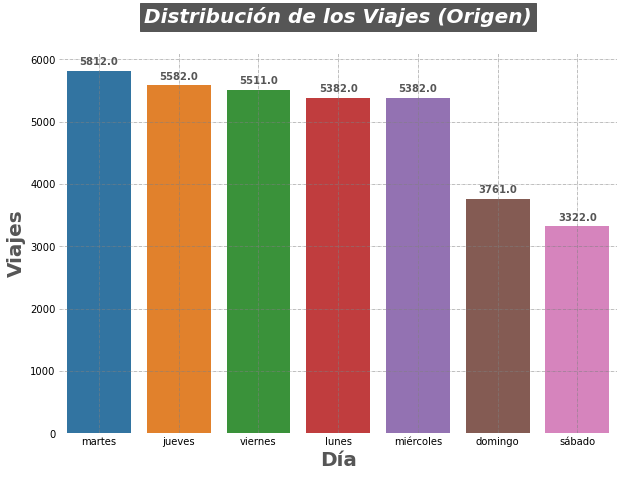

In [8]:
plt.figure(figsize=(10,7))
s = sns.barplot(x = df_día_semana_origen.día,
                y = df_día_semana_origen.viajes)
for p in s.patches:
    s.annotate(str(round(p.get_height(),4)), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   weight="bold",color="#565656")
plt.title("Distribución de los Viajes (Origen)", fontsize = 20,backgroundcolor="#565656",
  weight="bold",color="white",style="italic",loc="center",pad=30)
plt.xlabel('Día',weight="bold",size=20,color="#565656")
plt.ylabel('Viajes',weight="bold",size=20,color="#565656")
plt.tick_params(labelsize=10,length=0)
plt.box(False)
plt.grid(linewidth=0.5,color="grey",linestyle="-.")
plt.show()

Trabajamos ahora con los viajes con destino

In [9]:
df_día_semana_destino = df.groupby(['día_en_semana'],as_index=False).sum()[['día_en_semana','viajes_salientes']].rename({'día_en_semana' : 'día', 'viajes_salientes':'viajes'},axis=1).sort_values(by=['viajes'], ascending = False).iloc[0:10].reset_index(drop=True)
df_día_semana_destino['día'] = df_día_semana_destino['día'].map(días)
df_día_semana_destino

,día,viajes
0,martes,6035
1,jueves,5835
2,viernes,5751
3,miércoles,5725
4,lunes,5534
5,domingo,3910
6,sábado,3470


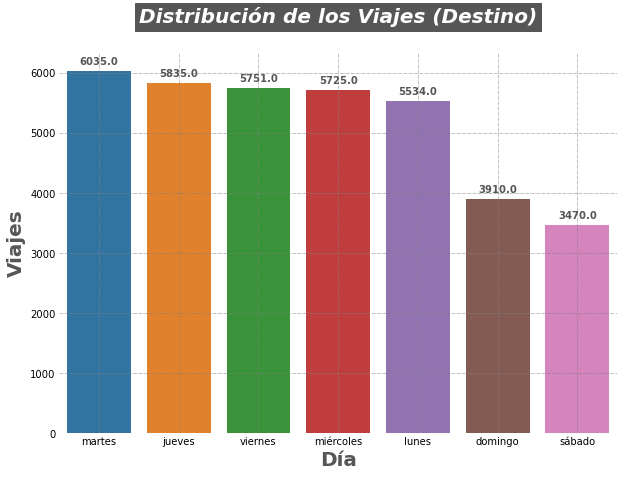

In [10]:
plt.figure(figsize=(10,7))
s = sns.barplot(x = df_día_semana_destino.día,
                y = df_día_semana_destino.viajes)
for p in s.patches:
    s.annotate(str(round(p.get_height(),4)), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   weight="bold",color="#565656")
plt.title("Distribución de los Viajes (Destino)", fontsize = 20,backgroundcolor="#565656",
  weight="bold",color="white",style="italic",loc="center",pad=30)
plt.xlabel('Día',weight="bold",size=20,color="#565656")
plt.ylabel('Viajes',weight="bold",size=20,color="#565656")
plt.tick_params(labelsize=10,length=0)
plt.box(False)
plt.grid(linewidth=0.5,color="grey",linestyle="-.")
plt.show()

# Seleccionamos nuestra estacion de interes 

In [11]:
#buscamos la estacion que tiene registra un mayor numero de viajes 

df_estación_origen = df.groupby(['estación'],as_index=False).sum()[['estación','viajes_entrantes']].rename({'viajes_entrantes':'viajes'},axis=1).sort_values(by=['viajes'], ascending = False).iloc[0:10].reset_index(drop=True)
df_estación_origen

,estación,viajes
0,014 - Pacifico,34752


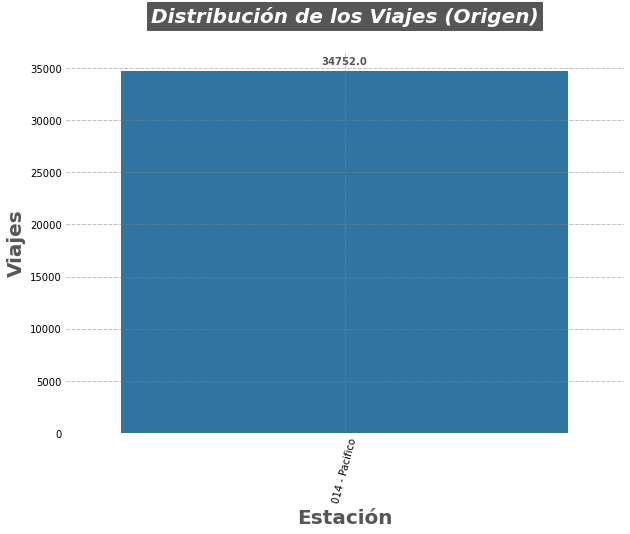

In [12]:
plt.figure(figsize=(10,7))
s = sns.barplot(x = df_estación_origen.estación,
            y = df_estación_origen.viajes)
for p in s.patches:
    s.annotate(str(round(p.get_height(),4)), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   weight="bold",color="#565656")
plt.title("Distribución de los Viajes (Origen)", fontsize = 20,backgroundcolor="#565656",
  weight="bold",color="white",style="italic",loc="center",pad=30)
plt.xlabel('Estación',weight="bold",size=20,color="#565656")
plt.xticks(rotation=75)
plt.ylabel('Viajes',weight="bold",size=20,color="#565656")
plt.tick_params(labelsize=10,length=0)
plt.box(False)
plt.grid(linewidth=0.5,color="grey",linestyle="-.")
plt.show()

In [13]:
df_estación_destino = df.groupby(['estación'],as_index=False).sum()[['estación','viajes_salientes']].rename({'viajes_salientes':'viajes'},axis=1).sort_values(by=['viajes'], ascending = False).iloc[0:10].reset_index(drop=True)
df_estación_destino

,estación,viajes
0,014 - Pacifico,36260


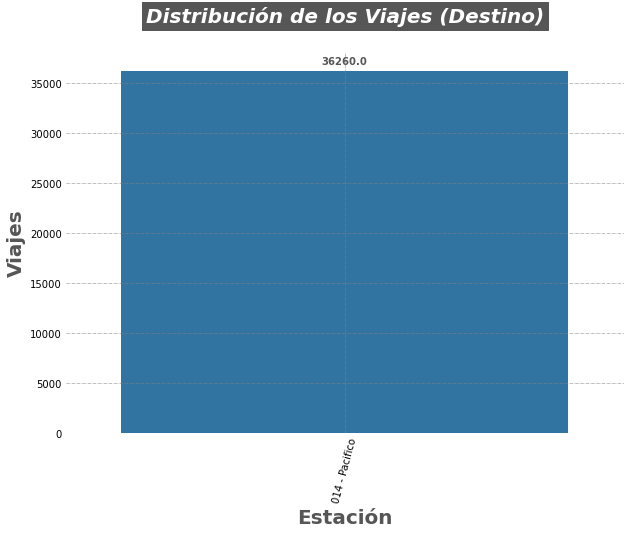

In [14]:
plt.figure(figsize=(10,7))
s = sns.barplot(x = df_estación_destino.estación,
            y = df_estación_destino.viajes)
for p in s.patches:
    s.annotate(str(round(p.get_height(),4)), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   weight="bold",color="#565656")
plt.title("Distribución de los Viajes (Destino)", fontsize = 20,backgroundcolor="#565656",
  weight="bold",color="white",style="italic",loc="center",pad=30)
plt.xlabel('Estación',weight="bold",size=20,color="#565656")
plt.xticks(rotation=75)
plt.ylabel('Viajes',weight="bold",size=20,color="#565656")
plt.tick_params(labelsize=10,length=0)
plt.box(False)
plt.grid(linewidth=0.5,color="grey",linestyle="-.")
plt.show()

In [15]:
#Analizamos en que horarios se registra mayor movimiento en la estacion de interes 

df_hora_origen = df.groupby(['hora'],as_index=False).sum()[['hora','viajes_entrantes']].rename({'viajes_entrantes':'viajes'},axis=1).sort_values(by=['viajes'], ascending = False).reset_index(drop=True)
df_hora_origen

,hora,viajes
0,18,3378
1,17,3213
2,19,3189
3,16,2735
4,20,2402
5,15,2277
6,13,2135
7,14,2009
8,12,2005
9,21,1588


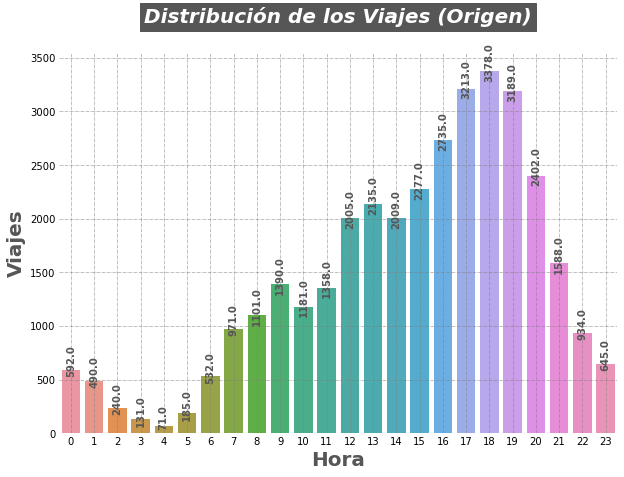

In [16]:
plt.figure(figsize=(10,7))
s = sns.barplot(x = df_hora_origen.hora,
            y = df_hora_origen.viajes)
for p in s.patches:
    s.annotate(str(round(p.get_height(),4)), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center',
                   rotation=90,
                   size=10,
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   weight="bold",color="#565656")
plt.title("Distribución de los Viajes (Origen)", fontsize = 20,backgroundcolor="#565656",
  weight="bold",color="white",style="italic",loc="center",pad=30)
plt.xlabel('Hora',weight="bold",size=20,color="#565656")
plt.xticks(rotation=0)
plt.ylabel('Viajes',weight="bold",size=20,color="#565656")
plt.tick_params(labelsize=10,length=0)
plt.box(False)
plt.grid(linewidth=0.5,color="grey",linestyle="-.")
plt.show()

In [17]:
df_hora_destino = df.groupby(['hora'],as_index=False).sum()[['hora','viajes_salientes']].rename({'viajes_salientes':'viajes'},axis=1).sort_values(by=['viajes'], ascending = False).reset_index(drop=True)
df_hora_destino

,hora,viajes
0,17,3322
1,18,3270
2,19,2885
3,16,2740
4,20,2434
5,15,2393
6,14,2296
7,13,2288
8,12,1800
9,11,1608


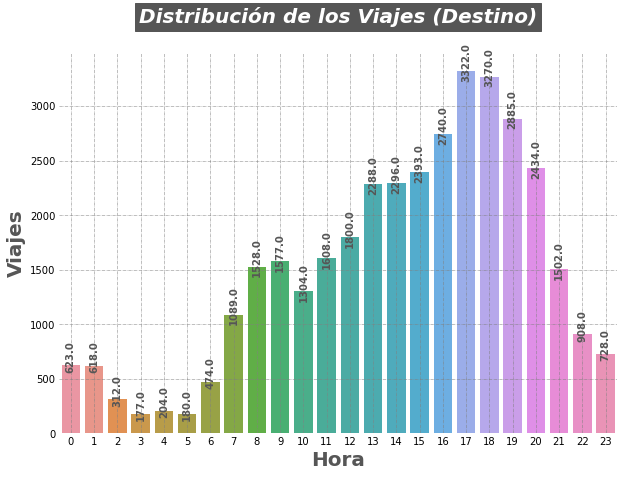

In [18]:
plt.figure(figsize=(10,7))
s = sns.barplot(x = df_hora_destino.hora,
            y = df_hora_destino.viajes)
for p in s.patches:
    s.annotate(str(round(p.get_height(),4)), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center',
                   rotation=90,
                   size=10,
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   weight="bold",color="#565656")
plt.title("Distribución de los Viajes (Destino)", fontsize = 20,backgroundcolor="#565656",
  weight="bold",color="white",style="italic",loc="center",pad=30)
plt.xlabel('Hora',weight="bold",size=20,color="#565656")
plt.xticks(rotation=0)
plt.ylabel('Viajes',weight="bold",size=20,color="#565656")
plt.tick_params(labelsize=10,length=0)
plt.box(False)
plt.grid(linewidth=0.5,color="grey",linestyle="-.")
plt.show()

In [19]:
#Selección columnas de interes
df = df.drop(['año'], axis = 1)

<AxesSubplot:>

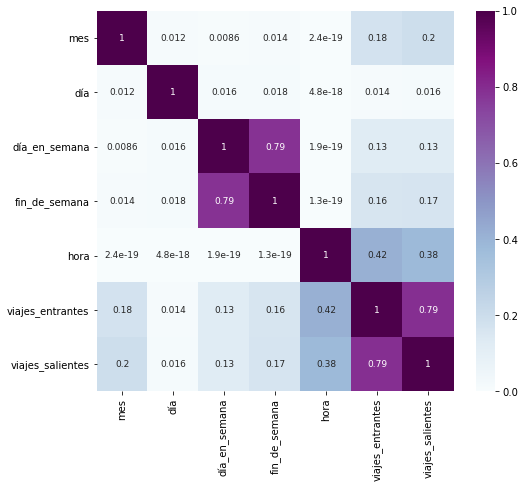

In [20]:
#Analizamos la correlación entre las variables
plt.figure(figsize=(8, 7))
sns.heatmap(abs(df.corr()), vmax = 1, annot=True, annot_kws={"size": 9}, cmap="BuPu")

In [21]:
#Correlación entre las variables
abs(df.corr()).transpose().loc[:, ["viajes_entrantes","viajes_salientes"]].sort_values(by="viajes_entrantes",ascending=False)

,viajes_entrantes,viajes_salientes
viajes_entrantes,1.000000,0.794323
viajes_salientes,0.794323,1.000000
hora,0.416533,0.382580
mes,0.175165,0.197332
fin_de_semana,0.161319,0.165835
día_en_semana,0.126822,0.127890
día,0.014376,0.016495


# Visualizamos el comportamiento de los viajes 

<AxesSubplot:>

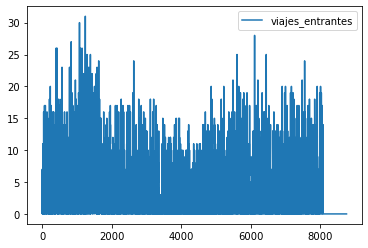

In [22]:
df.loc[ : , ['viajes_entrantes'] ].reset_index(drop=True).plot()

<AxesSubplot:>

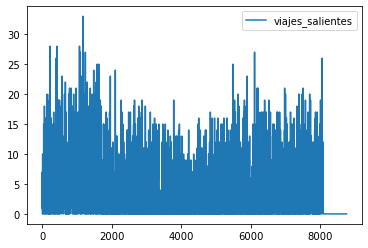

In [23]:
df.loc[ : , ['viajes_salientes'] ].reset_index(drop=True).plot()

<AxesSubplot:>

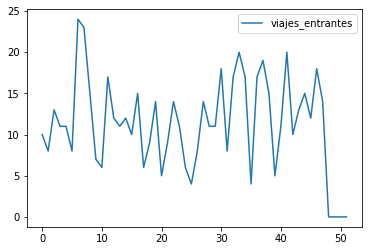

In [24]:
df.loc[ (df.día_en_semana == 1) & (df.hora == 18), ['viajes_entrantes'] ].reset_index(drop=True).plot()

<AxesSubplot:>

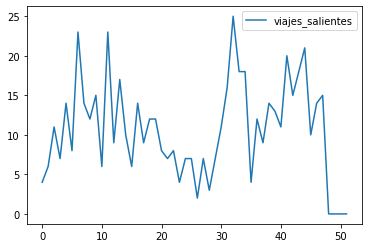

In [25]:
df.loc[ (df.día_en_semana == 1) & (df.hora == 18), ['viajes_salientes'] ].reset_index(drop=True).plot()

In [26]:
#Sumamos una columna correspondiente al dia anterior al que se encuentra registrado 

df.insert(loc=df.shape[1], column='fecha_1d', value=df.apply(lambda row : row['fecha'] - timedelta(days=1), axis = 1))
df.fecha_1d = pd.to_datetime(df['fecha_1d'])
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00


In [27]:
df['viajes_entrantes_1d'] = [ df.loc[ df.fecha == f, ['viajes_entrantes'] ].values[0][0] if f >= datetime(2021,1,1) else 0 for f in df['fecha_1d'] ]
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,viajes_entrantes_1d
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,0
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,0
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,0
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,0
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,0


In [28]:
df['viajes_salientes_1d'] = [ df.loc[ df.fecha == f, ['viajes_salientes'] ].values[0][0] if f >= datetime(2021,1,1) else 0 for f in df['fecha_1d'] ]
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,viajes_entrantes_1d,viajes_salientes_1d
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,0,0
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,0,0
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,0,0
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,0,0
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,0,0


In [29]:
df['viajes_entrantes_1d_ok'] = df.apply(lambda row : np.where(row['viajes_entrantes'] == row['viajes_entrantes_1d'] , 1, 0), axis = 1)
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,viajes_entrantes_1d,viajes_salientes_1d,viajes_entrantes_1d_ok
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,0,0,0
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,0,0,0
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,0,0,0
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,0,0,0
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,0,0,0


In [30]:
df['viajes_salientes_1d_ok'] = df.apply(lambda row : np.where(row['viajes_salientes'] == row['viajes_salientes_1d'] , 1, 0), axis = 1)
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,viajes_entrantes_1d,viajes_salientes_1d,viajes_entrantes_1d_ok,viajes_salientes_1d_ok
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,0,0,0,0
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,0,0,0,0
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,0,0,0,0
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,0,0,0,0
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,0,0,0,0


In [31]:
print('Viajes Entrantes 1 Días "Ok":',round(df.loc[ (df.viajes_entrantes_1d_ok == 1) , :].shape[0]/df.shape[0]*100,2),'%')

Viajes Entrantes 1 Días "Ok": 28.6 %


In [32]:
print('Viajes Salientes 1 Días "Ok":',round(df.loc[ (df.viajes_salientes_1d_ok == 1) , :].shape[0]/df.shape[0]*100,2),'%')

Viajes Salientes 1 Días "Ok": 26.62 %


In [33]:
df_métricas = pd.DataFrame(data = { 'métrica' : ['Promedio 1 Día Antes'], 'viajes_entrantes_ok_%' : [round(df.loc[ (df.viajes_entrantes_1d_ok == 1) , :].shape[0]/df.shape[0]*100,2)], 'viajes_salientes_ok_%' : [round(df.loc[ (df.viajes_salientes_1d_ok == 1) , :].shape[0]/df.shape[0]*100,2)] }  )
df_métricas

,métrica,viajes_entrantes_ok_%,viajes_salientes_ok_%
0,Promedio 1 Día Antes,28.6,26.62


<AxesSubplot:>

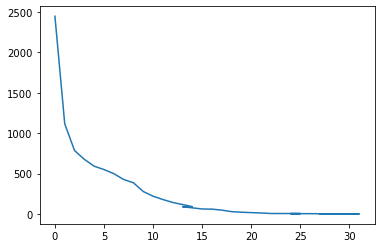

In [34]:
df.viajes_entrantes_1d.value_counts().plot()

<AxesSubplot:>

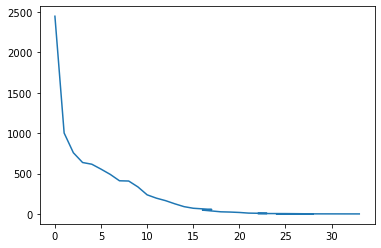

In [35]:
df.viajes_salientes_1d.value_counts().plot()

In [36]:
df.insert(loc=df.shape[1], column='fecha_7d', value=df.apply(lambda row : row['fecha'] - timedelta(days=7), axis = 1))
df.fecha_7d = pd.to_datetime(df['fecha_7d'])
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,viajes_entrantes_1d,viajes_salientes_1d,viajes_entrantes_1d_ok,viajes_salientes_1d_ok,fecha_7d
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,0,0,0,0,2020-12-25 00:00:00
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,0,0,0,0,2020-12-25 01:00:00
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,0,0,0,0,2020-12-25 02:00:00
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,0,0,0,0,2020-12-25 03:00:00
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,0,0,0,0,2020-12-25 04:00:00


In [37]:
df['viajes_entrantes_7d'] = [ df.loc[ df.fecha == f, ['viajes_entrantes'] ].values[0][0] if f >= datetime(2021,1,1) else 0 for f in df['fecha_7d'] ]
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,viajes_entrantes_1d,viajes_salientes_1d,viajes_entrantes_1d_ok,viajes_salientes_1d_ok,fecha_7d,viajes_entrantes_7d
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,0,0,0,0,2020-12-25 00:00:00,0
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,0,0,0,0,2020-12-25 01:00:00,0
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,0,0,0,0,2020-12-25 02:00:00,0
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,0,0,0,0,2020-12-25 03:00:00,0
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,0,0,0,0,2020-12-25 04:00:00,0


In [38]:
df['viajes_salientes_7d'] = [ df.loc[ df.fecha == f, ['viajes_salientes'] ].values[0][0] if f >= datetime(2021,1,1) else 0 for f in df['fecha_7d'] ]
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,viajes_entrantes_1d,viajes_salientes_1d,viajes_entrantes_1d_ok,viajes_salientes_1d_ok,fecha_7d,viajes_entrantes_7d,viajes_salientes_7d
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,0,0,0,0,2020-12-25 00:00:00,0,0
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,0,0,0,0,2020-12-25 01:00:00,0,0
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,0,0,0,0,2020-12-25 02:00:00,0,0
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,0,0,0,0,2020-12-25 03:00:00,0,0
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,0,0,0,0,2020-12-25 04:00:00,0,0


In [39]:
df['viajes_entrantes_7d_ok'] = df.apply(lambda row : np.where(row['viajes_entrantes'] == row['viajes_entrantes_7d'] , 1, 0), axis = 1)
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,viajes_entrantes_1d,viajes_salientes_1d,viajes_entrantes_1d_ok,viajes_salientes_1d_ok,fecha_7d,viajes_entrantes_7d,viajes_salientes_7d,viajes_entrantes_7d_ok
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,0,0,0,0,2020-12-25 00:00:00,0,0,0
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,0,0,0,0,2020-12-25 01:00:00,0,0,0
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,0,0,0,0,2020-12-25 02:00:00,0,0,0
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,0,0,0,0,2020-12-25 03:00:00,0,0,0
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,0,0,0,0,2020-12-25 04:00:00,0,0,0


In [40]:
df['viajes_salientes_7d_ok'] = df.apply(lambda row : np.where(row['viajes_salientes'] == row['viajes_salientes_7d'] , 1, 0), axis = 1)
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,viajes_entrantes_1d,viajes_salientes_1d,viajes_entrantes_1d_ok,viajes_salientes_1d_ok,fecha_7d,viajes_entrantes_7d,viajes_salientes_7d,viajes_entrantes_7d_ok,viajes_salientes_7d_ok
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,0,0,0,0,2020-12-25 00:00:00,0,0,0,0
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,0,0,0,0,2020-12-25 01:00:00,0,0,0,0
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,0,0,0,0,2020-12-25 02:00:00,0,0,0,0
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,0,0,0,0,2020-12-25 03:00:00,0,0,0,0
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,0,0,0,0,2020-12-25 04:00:00,0,0,0,0


In [164]:
print('Viajes Entrantes 7 Días "Ok":',round(df.loc[ (df.viajes_entrantes_7d_ok == 1) , :].shape[0]/df.shape[0]*100,2),'%')
print('Viajes Salientes 7 Días "Ok":',round(df.loc[ (df.viajes_salientes_7d_ok == 1) , :].shape[0]/df.shape[0]*100,2),'%')

Viajes Entrantes 7 Días "Ok": 27.52 %
Viajes Salientes 7 Días "Ok": 25.95 %


In [43]:
df_métricas = df_métricas.append({ 'métrica' : 'Promedio 7 Días Antes', 'viajes_entrantes_ok_%' : round(df.loc[ (df.viajes_entrantes_7d_ok == 1) , :].shape[0]/df.shape[0]*100,2), 'viajes_salientes_ok_%' : round(df.loc[ (df.viajes_salientes_7d_ok == 1) , :].shape[0]/df.shape[0]*100,2) }, ignore_index = True)
df_métricas

,métrica,viajes_entrantes_ok_%,viajes_salientes_ok_%
0,Promedio 1 Día Antes,28.60,26.62
1,Promedio 7 Días Antes,27.52,25.95


<AxesSubplot:>

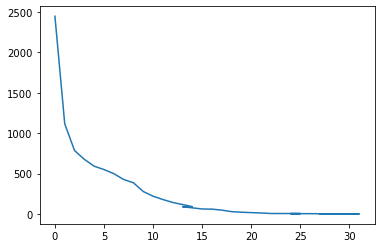

In [44]:
df.viajes_entrantes_7d.value_counts().plot()

<AxesSubplot:>

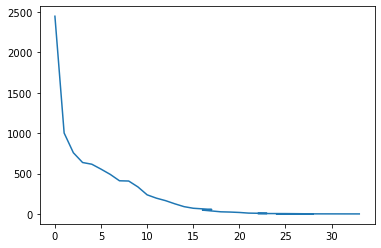

In [45]:
df.viajes_salientes_7d.value_counts().plot()

# Buscamos el mejor modelo para poder predecir

In [46]:
X = df[['mes','fin_de_semana','hora']]
y = df[['viajes_entrantes']]

print(X.columns)
print(y.columns)

Index(['mes', 'fin_de_semana', 'hora'], dtype='object')
Index(['viajes_entrantes'], dtype='object')


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 42)

 Aplicamos una pipeline que nos compare todos los modelos en simultaneo

In [48]:
pipelines = []

pipelines.append(('ScaledCART', Pipeline([('Scaler', RobustScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledRFR', Pipeline([('Scaler', RobustScaler()),('RFR', RandomForestRegressor(max_depth = 5))])))
pipelines.append(('ScaledLR', Pipeline([('Scaler', RobustScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', RobustScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', RobustScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', RobustScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', RobustScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', RobustScaler()),('SVR', SVR())])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=5, random_state=21, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledCART: -7.950931 (0.422170)
ScaledRFR: -9.163497 (0.350770)
ScaledLR: -15.156312 (0.344055)
ScaledLASSO: -19.170814 (0.617495)
ScaledEN: -18.368848 (0.440016)
ScaledKNN: -8.612972 (0.425831)
ScaledGBM: -7.886278 (0.297000)
ScaledSVR: -10.256383 (0.342692)


In [49]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [50]:
#Tomamos un dia aleatorio en el horario de mayor frecuencia de vaijes 
mes = 1
fin_de_semana = 1
hora = 18

Realizamos una primera prediccion con nuestro modelo, presentandole datos aleatorios

In [51]:
print("Estimación de viajes entrantes para el Mes",mes,"/ Fin de Semana",fin_de_semana,"/ Hora", hora,":",int(gb.predict([[mes,fin_de_semana,hora]])))

Estimación de viajes entrantes para el Mes 1 / Fin de Semana 1 / Hora 18 : 12


In [52]:
#buscamos e valor 
df.loc[  (df.mes == mes) & (df.fin_de_semana == fin_de_semana) & (df.hora == hora), ['viajes_entrantes'] ].reset_index(drop=True).mean()

viajes_entrantes    14.0
dtype: float64

In [53]:
#1 Día
df.loc[  (df.mes == mes) & (df.fin_de_semana == fin_de_semana) & (df.hora == hora), ['viajes_entrantes_1d'] ].reset_index(drop=True).mean()

viajes_entrantes_1d    10.2
dtype: float64

In [54]:
#7 Días
df.loc[  (df.mes == mes) & (df.fin_de_semana == fin_de_semana) & (df.hora == hora), ['viajes_entrantes_7d'] ].reset_index(drop=True).mean()

viajes_entrantes_7d    12.8
dtype: float64

In [55]:
df.insert(loc=df.shape[1], column='viajes_entrantes_gb', value=df.apply(lambda row : int(gb.predict([[row['mes'], row['fin_de_semana'], row['hora']]])), axis = 1))
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,viajes_entrantes_1d,viajes_salientes_1d,viajes_entrantes_1d_ok,viajes_salientes_1d_ok,fecha_7d,viajes_entrantes_7d,viajes_salientes_7d,viajes_entrantes_7d_ok,viajes_salientes_7d_ok,viajes_entrantes_gb
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,0,0,0,0,2020-12-25 00:00:00,0,0,0,0,2
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,0,0,0,0,2020-12-25 01:00:00,0,0,0,0,2
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,0,0,0,0,2020-12-25 02:00:00,0,0,0,0,0
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,0,0,0,0,2020-12-25 03:00:00,0,0,0,0,0
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,0,0,0,0,2020-12-25 04:00:00,0,0,0,0,0


In [56]:
X = df[['mes','fin_de_semana','hora']]
y = df[['viajes_salientes']]

print(X.columns)
print(y.columns)

Index(['mes', 'fin_de_semana', 'hora'], dtype='object')
Index(['viajes_salientes'], dtype='object')


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 42)

In [58]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [59]:
df.insert(loc=df.shape[1], column='viajes_salientes_gb', value=df.apply(lambda row : int(gb.predict([[row['mes'], row['fin_de_semana'], row['hora']]])), axis = 1))
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,...,viajes_salientes_1d,viajes_entrantes_1d_ok,viajes_salientes_1d_ok,fecha_7d,viajes_entrantes_7d,viajes_salientes_7d,viajes_entrantes_7d_ok,viajes_salientes_7d_ok,viajes_entrantes_gb,viajes_salientes_gb
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,...,0,0,0,2020-12-25 00:00:00,0,0,0,0,2,3
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,...,0,0,0,2020-12-25 01:00:00,0,0,0,0,2,3
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,...,0,0,0,2020-12-25 02:00:00,0,0,0,0,0,1
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,...,0,0,0,2020-12-25 03:00:00,0,0,0,0,0,1
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,...,0,0,0,2020-12-25 04:00:00,0,0,0,0,0,1


In [60]:
df['viajes_entrantes_gb_ok'] = df.apply(lambda row : np.where(row['viajes_entrantes'] == row['viajes_entrantes_gb'] , 1, 0), axis = 1)
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,...,viajes_entrantes_1d_ok,viajes_salientes_1d_ok,fecha_7d,viajes_entrantes_7d,viajes_salientes_7d,viajes_entrantes_7d_ok,viajes_salientes_7d_ok,viajes_entrantes_gb,viajes_salientes_gb,viajes_entrantes_gb_ok
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,...,0,0,2020-12-25 00:00:00,0,0,0,0,2,3,1
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,...,0,0,2020-12-25 01:00:00,0,0,0,0,2,3,0
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,...,0,0,2020-12-25 02:00:00,0,0,0,0,0,1,0
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,...,0,0,2020-12-25 03:00:00,0,0,0,0,0,1,0
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,...,0,0,2020-12-25 04:00:00,0,0,0,0,0,1,0


In [61]:
df['viajes_salientes_gb_ok'] = df.apply(lambda row : np.where(row['viajes_salientes'] == row['viajes_salientes_gb'] , 1, 0), axis = 1)
df.head()

,estación,fecha,mes,día,día_en_semana,fin_de_semana,hora,viajes_entrantes,viajes_salientes,fecha_1d,...,viajes_salientes_1d_ok,fecha_7d,viajes_entrantes_7d,viajes_salientes_7d,viajes_entrantes_7d_ok,viajes_salientes_7d_ok,viajes_entrantes_gb,viajes_salientes_gb,viajes_entrantes_gb_ok,viajes_salientes_gb_ok
0,014 - Pacifico,2021-01-01 00:00:00,1,1,4,0,0,2,1,2020-12-31 00:00:00,...,0,2020-12-25 00:00:00,0,0,0,0,2,3,1,0
1,014 - Pacifico,2021-01-01 01:00:00,1,1,4,0,1,5,7,2020-12-31 01:00:00,...,0,2020-12-25 01:00:00,0,0,0,0,2,3,0,0
2,014 - Pacifico,2021-01-01 02:00:00,1,1,4,0,2,7,2,2020-12-31 02:00:00,...,0,2020-12-25 02:00:00,0,0,0,0,0,1,0,0
3,014 - Pacifico,2021-01-01 03:00:00,1,1,4,0,3,2,1,2020-12-31 03:00:00,...,0,2020-12-25 03:00:00,0,0,0,0,0,1,0,1
4,014 - Pacifico,2021-01-01 04:00:00,1,1,4,0,4,2,2,2020-12-31 04:00:00,...,0,2020-12-25 04:00:00,0,0,0,0,0,1,0,0


In [165]:
print('Viajes Entrantes Gb "Ok":',round(df.loc[ (df.viajes_entrantes_gb_ok == 1) , :].shape[0]/df.shape[0]*100,2),'%')
print('Viajes Salientes Gb "Ok":',round(df.loc[ (df.viajes_salientes_gb_ok == 1) , :].shape[0]/df.shape[0]*100,2),'%')

Viajes Entrantes Gb "Ok": 30.68 %
Viajes Salientes Gb "Ok": 27.87 %


In [64]:
df_métricas = df_métricas.append({ 'métrica' : 'GradientBoostingRegressor', 'viajes_entrantes_ok_%' : round(df.loc[ (df.viajes_entrantes_gb_ok == 1) , :].shape[0]/df.shape[0]*100,2), 'viajes_salientes_ok_%' : round(df.loc[ (df.viajes_salientes_gb_ok == 1) , :].shape[0]/df.shape[0]*100,2) }, ignore_index = True)
df_métricas

,métrica,viajes_entrantes_ok_%,viajes_salientes_ok_%
0,Promedio 1 Día Antes,28.60,26.62
1,Promedio 7 Días Antes,27.52,25.95
2,GradientBoostingRegressor,30.68,27.87


# Modelo de Forecast 

# Trabajamos con Viajes Salientes en fin de semana

In [65]:
#dividimos el data set tomando solo los primeros 5 meses para testear, los demas meses pueden ser utilizados para validar
X = df.loc[df.mes<=5][['mes','fin_de_semana','hora']]
y = df.loc[df.mes<=5][['viajes_salientes']]

#Importamos nuestro split 
from sklearn.model_selection import TimeSeriesSplit

#Me divide el data set en 5 siguiendo su indice:
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

#usamos esta division de train/test, para poder predecir 2 semanas
steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [66]:
print(X_train)
24*30

      mes  fin_de_semana  hora
0       1              0     0
1       1              0     1
2       1              0     2
3       1              0     3
4       1              0     4
...   ...            ...   ...
2899    5              1    19
2900    5              1    20
2901    5              1    21
2902    5              1    22
2903    5              1    23

[2904 rows x 3 columns]


720

Realizamos una prediccion con nuestro mejor modelo sin toonear 

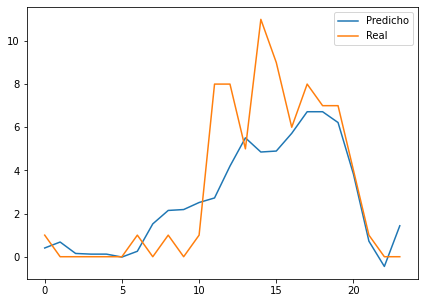

In [68]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred.size

#Visualizamos la performance del modelo 
plt.figure(figsize=(7,5))
plt.plot(y_pred[:24], label = 'Predicho')
plt.plot(y_test.values[:24], label = 'Real')

plt.legend()
plt.show()

In [69]:
print (((np.abs(y_pred[:24] - y_test.values[:24]))).sum() / y_test.values[:24].sum())
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")

25.69179218663827
Test error (mse): 8.12674854767922


Buscamos los mejores hiperparametros para nuestro modelo a traves de un grid search y un tscv

In [70]:
parameters = {'n_estimators':[25,30,35,40], 'ccp_alpha':np.linspace(0.01,0.2,10), 'learning_rate':np.linspace(0.01,0.2,10)}
gb = GradientBoostingRegressor()
clf = GridSearchCV(gb, parameters, cv = tscv)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print (clf.best_params_)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
y_pred.shape

{'ccp_alpha': 0.01, 'learning_rate': 0.1366666666666667, 'n_estimators': 40}
Test error (mse): 8.089836670081185


(720,)

Visualizamos el comportamiento de nuestro modelo frente a la realidad para los viajes salientes en fin de semana

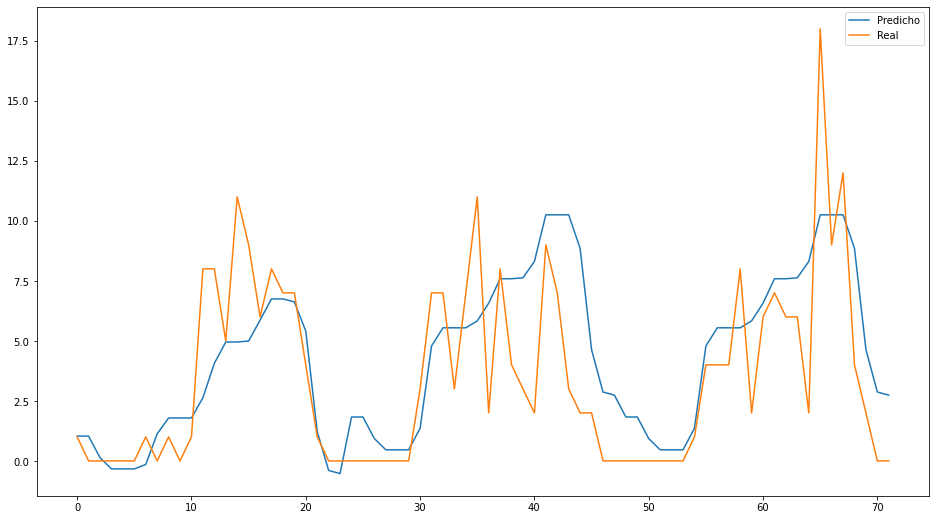

In [71]:
#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
#plt.plot(y_pred_2, label = 'Predicho 2')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

In [72]:
y_pred.shape
y_test.shape
(np.abs(y_pred - y_test.values[:,0])).sum() / y_test.values[:,0].sum()

0.6176124053815919

# Trabajamos con Viajes Entrantes en fin de semana

In [74]:
#dividimos el data set tomando solo los primeros 5 meses para testear, los demas meses pueden ser utilizados para validar
X = df.loc[df.mes<=5][['mes','fin_de_semana','hora']]
y = df.loc[df.mes<=5][['viajes_entrantes']]

#usamos esta division de train/test, para poder predecir 1 mes 
steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

#Buscamos los mejores hiperparametros para nuestro modelo a traves de un grid search y un tscv y vemos las metricas de interes

parameters = {'n_estimators':[25,30,35,40], 'ccp_alpha':np.linspace(0.01,0.2,10), 'learning_rate':np.linspace(0.01,0.2,10)}
gb = GradientBoostingRegressor()
clf = GridSearchCV(gb, parameters, cv = tscv)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print (clf.best_params_)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
print(y_pred.shape)

{'ccp_alpha': 0.01, 'learning_rate': 0.2, 'n_estimators': 30}
Test error (mse): 7.33303941708313
(720,)


Visualizamos el comportamiento de nuestro modelo frente a la realidad para los viajes entrantes en fin de semana

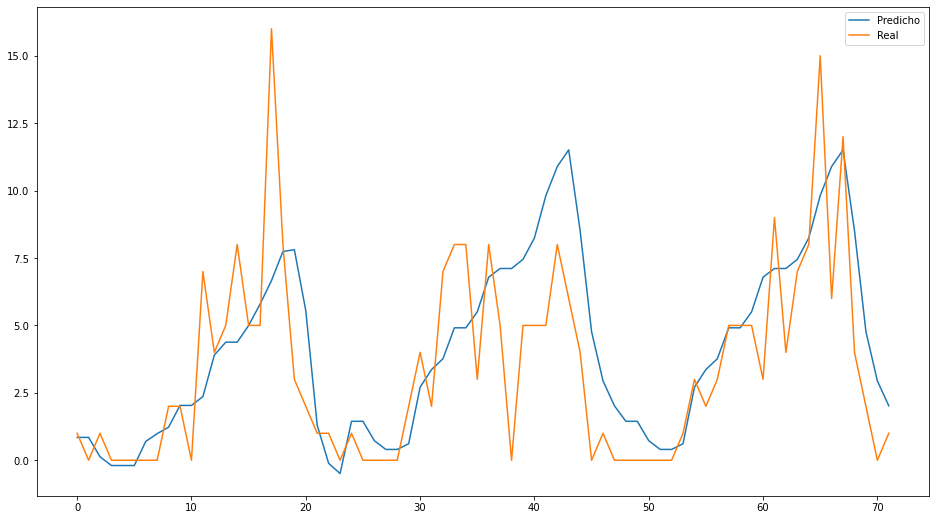

In [75]:
#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
#plt.plot(y_pred_2, label = 'Predicho 2')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

In [76]:
y_pred.shape
y_test.shape
(np.abs(y_pred - y_test.values[:,0])).sum() / y_test.values[:,0].sum()

0.601901840419156

# Trabajamos con Viajes Salientes en dias de semana

Viajes Salientes para dias de semana

In [78]:
#dividimos el data set tomando solo los primeros 5 meses para testear, los demas meses pueden ser utilizados para validar
X = df.loc[df.mes<=5][['mes','día_en_semana','hora']]
y = df.loc[df.mes<=5][['viajes_salientes']]

#usamos esta division de train/test, para poder predecir 1 mes 
steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

#Buscamos los mejores hiperparametros para nuestro modelo a traves de un grid search y un tscv y vemos las metricas de interes

parameters = {'n_estimators':[25,30,35,40], 'ccp_alpha':np.linspace(0.01,0.2,10), 'learning_rate':np.linspace(0.01,0.2,10)}
gb = GradientBoostingRegressor()
clf = GridSearchCV(gb, parameters, cv = tscv)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print (clf.best_params_)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
#print(y_pred)
y_pred.shape

{'ccp_alpha': 0.01, 'learning_rate': 0.2, 'n_estimators': 40}
Test error (mse): 8.558714802478667


(720,)

Visualizamos el comportamiento de nuestro modelo frente a la realidad para los viajes salientes en dia de semana

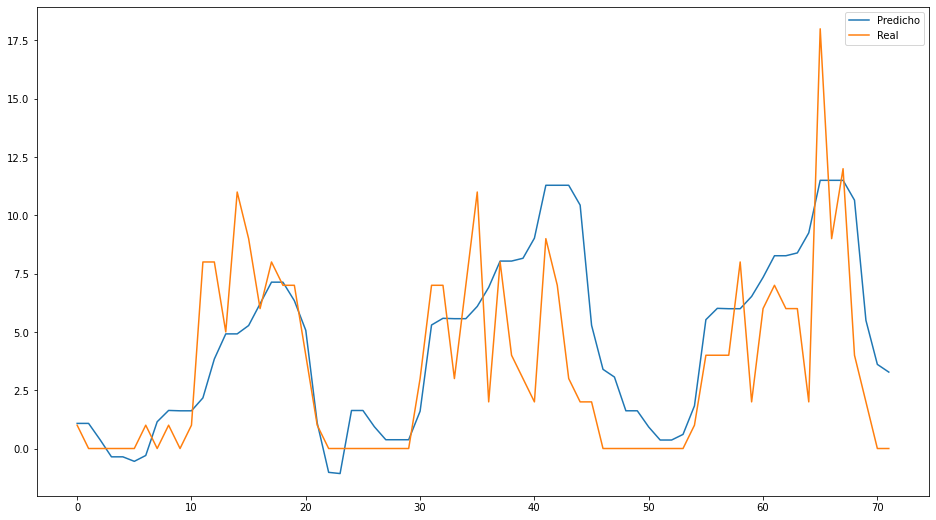

In [79]:
#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

# Trabajamos con Viajes Entrante en dias de semana

In [80]:
#dividimos el data set tomando solo los primeros 5 meses para testear, los demas meses pueden ser utilizados para validar
X = df.loc[df.mes<=5][['mes','día_en_semana','hora']]
y = df.loc[df.mes<=5][['viajes_entrantes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

#Buscamos los mejores hiperparametros para nuestro modelo a traves de un grid search y un tscv

parameters = {'n_estimators':[25,30,35,40], 'ccp_alpha':np.linspace(0.01,0.2,10), 'learning_rate':np.linspace(0.01,0.2,10)}
gb = GradientBoostingRegressor()
clf = GridSearchCV(gb, parameters, cv = tscv)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print (clf.best_params_)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
#print(y_pred)
y_pred.shape

{'ccp_alpha': 0.01, 'learning_rate': 0.1577777777777778, 'n_estimators': 30}
Test error (mse): 7.699027651376866


(720,)

Visualizamos el comportamiento de nuestro modelo frente a la realidad para los viajes entrantes en dia de semana

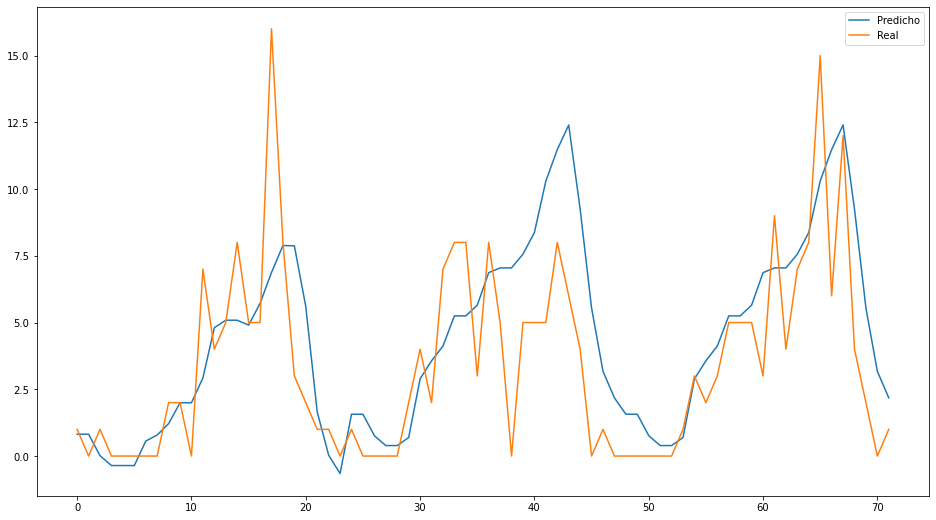

In [81]:
#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

# Validacion 

Defino un Gradient Boosting para cada tipo de viaje

In [82]:
#Params viajes salientes en fin de semana : 'ccp_alpha': 0.01, 'learning_rate': 0.1366666666666667, 'n_estimators': 40
gb_tr_sf = GradientBoostingRegressor(n_estimators = 40, learning_rate = 0.1366666666666667, ccp_alpha = 0.01)

#Params viajes entrantes en fin de semana :'ccp_alpha': 0.01, 'learning_rate': 0.2, 'n_estimators': 35
gb_tr_ef = GradientBoostingRegressor(n_estimators = 35, learning_rate = 0.2, ccp_alpha = 0.01)

#Params viajes salientes en dia de semana : 'ccp_alpha': 0.01, 'learning_rate': 0.2, 'n_estimators': 30
gb_tr_ss = GradientBoostingRegressor(n_estimators = 30, learning_rate = 0.2, ccp_alpha = 0.01)

#Params viajes entrantes en dia de semana : 'ccp_alpha': 0.01, 'learning_rate': 0.1577777777777778, 'n_estimators': 30
gb_tr_es = GradientBoostingRegressor(n_estimators = 30, learning_rate = 0.1577777777777778, ccp_alpha = 0.01)

# Validamos para viajes correspondientes al mes de Junio 

Test error (mse): 5.115208528777808
(720,)


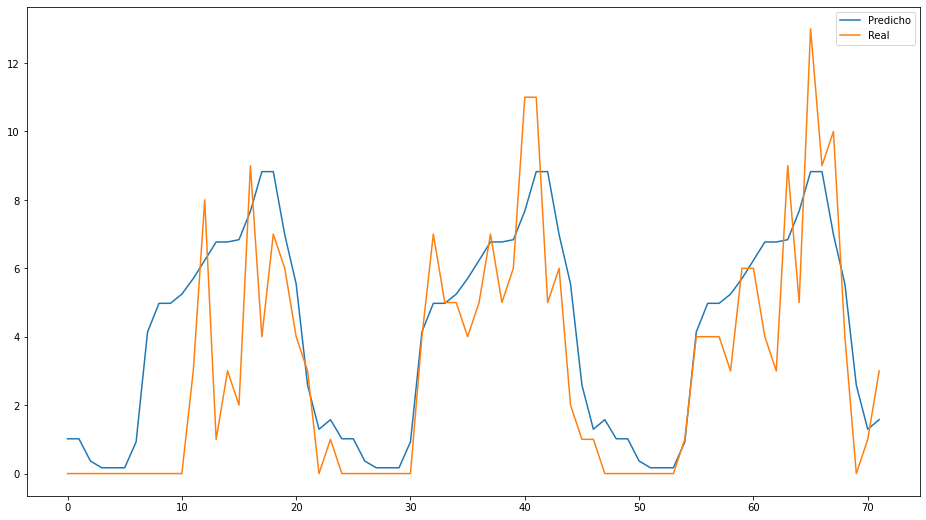

In [125]:
#Viajes salientes en fin de semana 
X = df.loc[df.mes<=6][['mes','fin_de_semana','hora']]
y = df.loc[df.mes<=6][['viajes_salientes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

gb_tr_sf.fit(X_train, y_train)
y_pred = gb_tr_sf.predict(X_test)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
print(y_pred.shape)

#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

Test error (mse): 5.334695586244619
(720,)


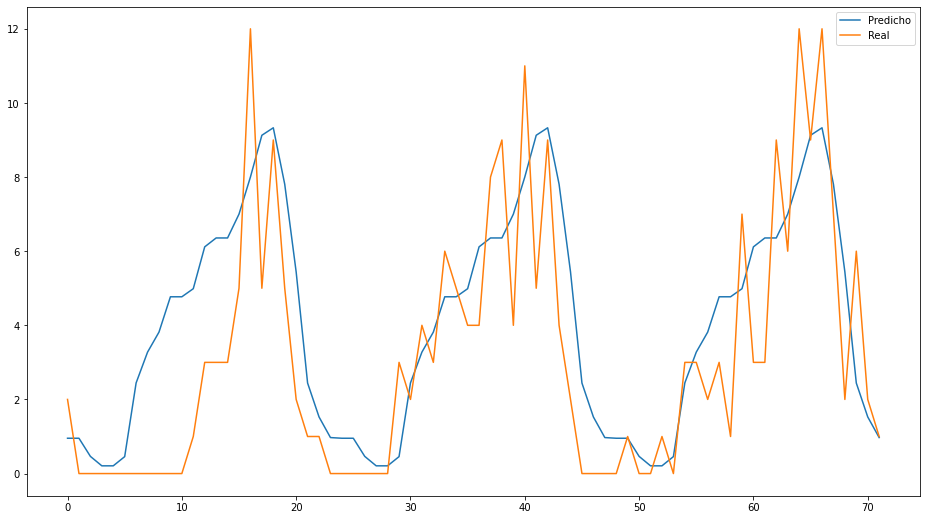

In [126]:
#Viajes entrantes en fin de semana
X = df.loc[df.mes<=6][['mes','fin_de_semana','hora']]
y = df.loc[df.mes<=6][['viajes_entrantes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

gb_tr_ef.fit(X_train, y_train)
y_pred = gb_tr_ef.predict(X_test)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
print(y_pred.shape)

#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

Test error (mse): 5.263641827680508
(720,)


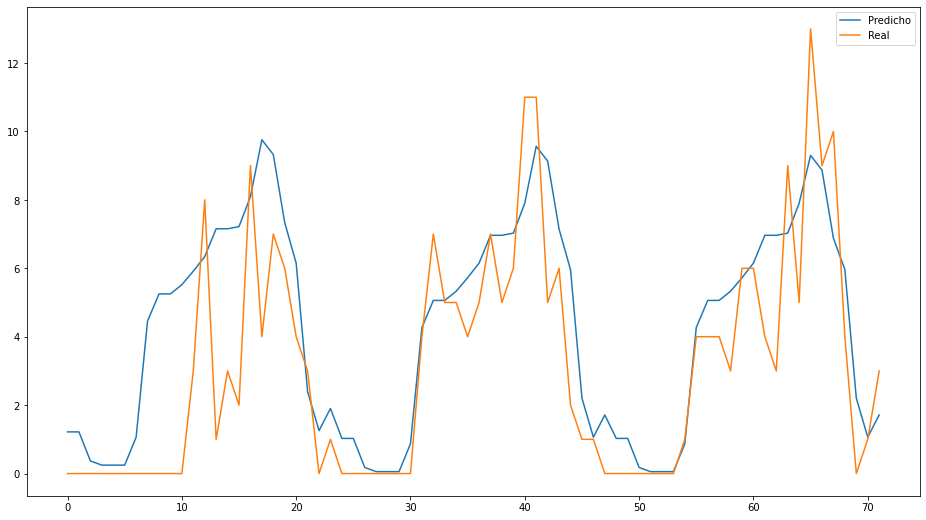

In [127]:
#Viajes salientes entre semana

X = df.loc[df.mes<=6][['mes','día_en_semana','hora']]
y = df.loc[df.mes<=6][['viajes_salientes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]


gb_tr_ss.fit(X_train, y_train)
y_pred = gb_tr_ss.predict(X_test)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
print(y_pred.shape)

#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

Test error (mse): 5.5368121626956235
(720,)


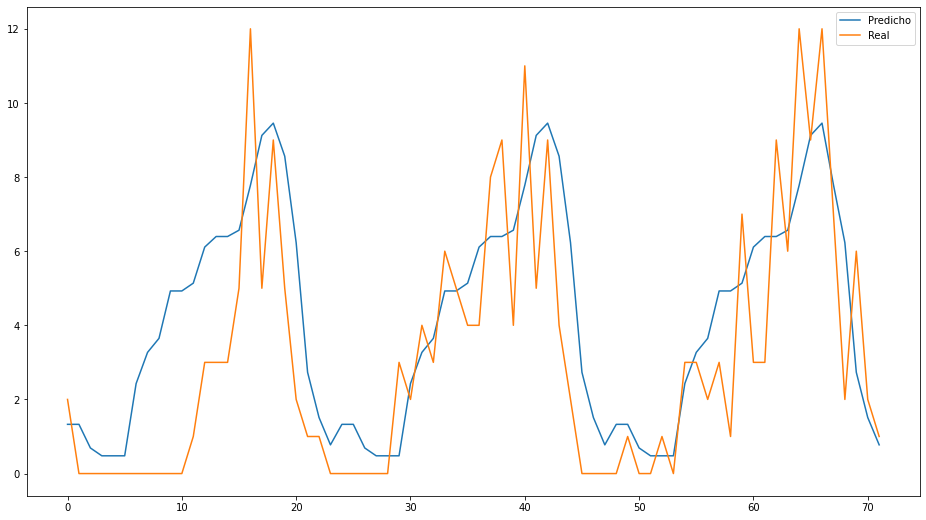

In [128]:
#Viajes entrantes entre semana 

X = df.loc[df.mes<=6][['mes','día_en_semana','hora']]
y = df.loc[df.mes<=6][['viajes_entrantes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

gb_tr_es.fit(X_train, y_train)
y_pred = gb_tr_es.predict(X_test)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
print(y_pred.shape)

#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

# Validamos para viajes correspondientes al mes de Agosto

Test error (mse): 9.121296244808622
(720,)


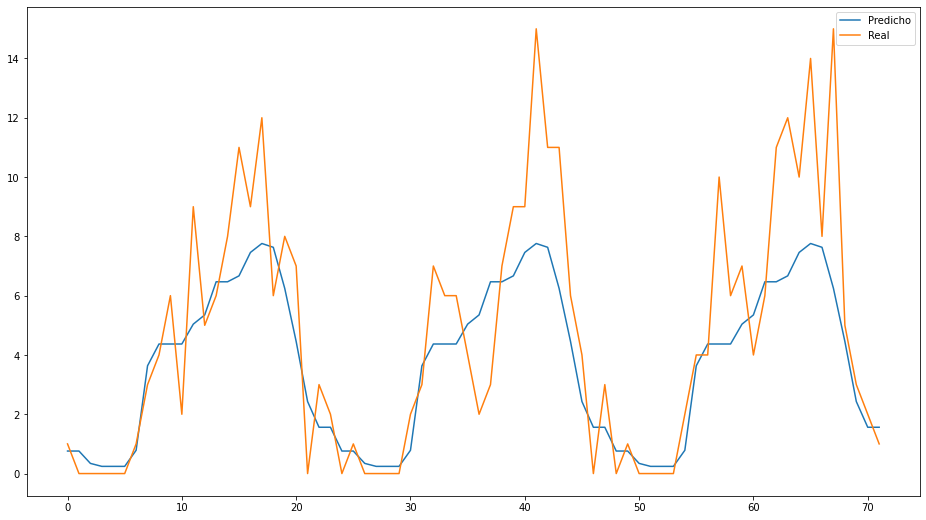

In [129]:
#Viajes salientes en fin de semana 
X = df.loc[df.mes<=8][['mes','fin_de_semana','hora']]
y = df.loc[df.mes<=8][['viajes_salientes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

gb_tr_sf.fit(X_train, y_train)
y_pred = gb_tr_sf.predict(X_test)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
print(y_pred.shape)

#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

Test error (mse): 9.398362379917547
(720,)


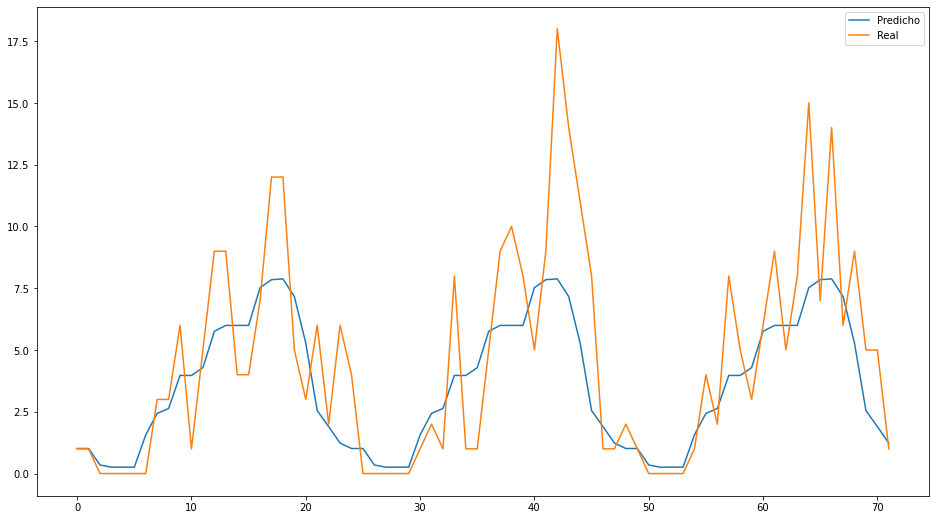

In [130]:
#Viajes entrantes en fin de semana
X = df.loc[df.mes<=8][['mes','fin_de_semana','hora']]
y = df.loc[df.mes<=8][['viajes_entrantes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

gb_tr_ef.fit(X_train, y_train)
y_pred = gb_tr_ef.predict(X_test)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
#print(y_pred)
print(y_pred.shape)

#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

Test error (mse): 9.146535292047258
(720,)


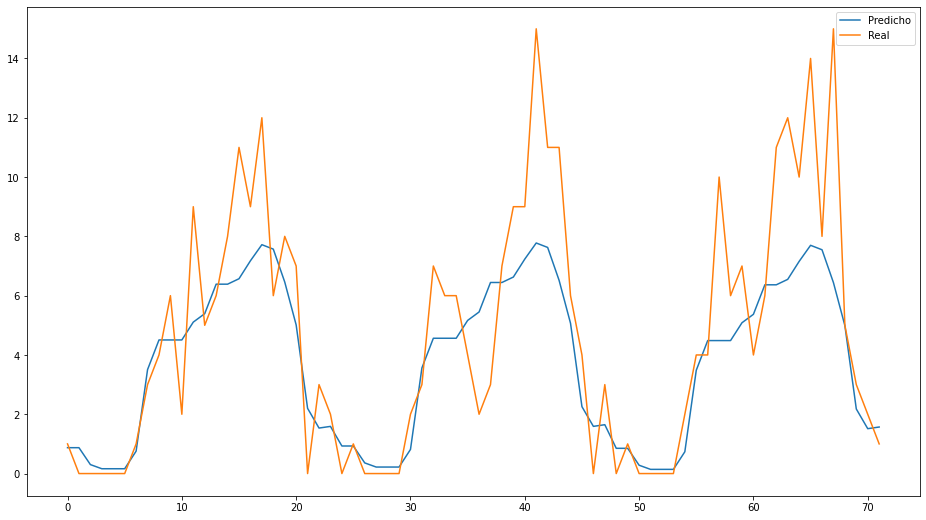

In [131]:
#Viajes salientes entre semana

X = df.loc[df.mes<=8][['mes','día_en_semana','hora']]
y = df.loc[df.mes<=8][['viajes_salientes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]
gb_tr_ss.fit(X_train, y_train)
y_pred = gb_tr_ss.predict(X_test)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
print(y_pred.shape)

#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

Test error (mse): 9.47235482606512
(720,)


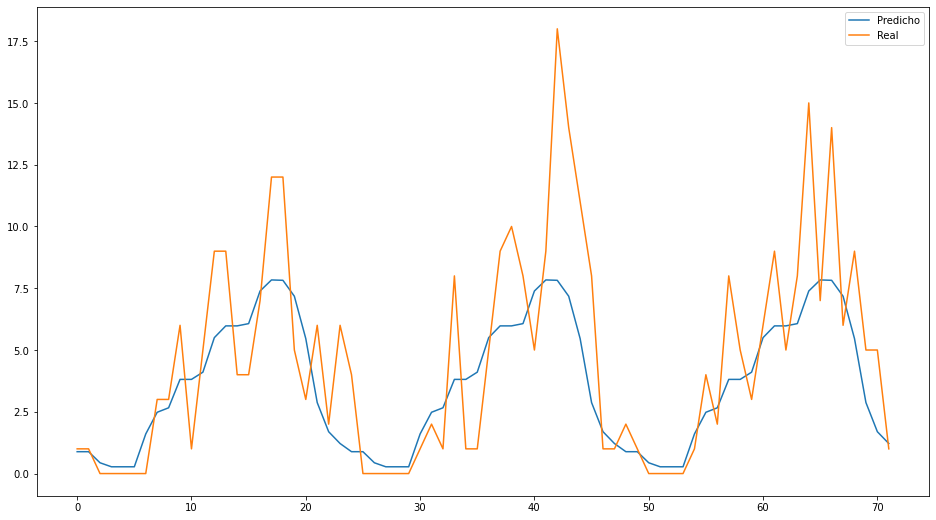

In [132]:
#Viajes entrantes entre semana 

X = df.loc[df.mes<=8][['mes','día_en_semana','hora']]
y = df.loc[df.mes<=8][['viajes_entrantes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

gb_tr_es.fit(X_train, y_train)
y_pred = gb_tr_es.predict(X_test)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
print(y_pred.shape)

#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

# Validamos para viajes correspondientes al mes de Noviembre

Test error (mse): 9.314364127729686
(720,)


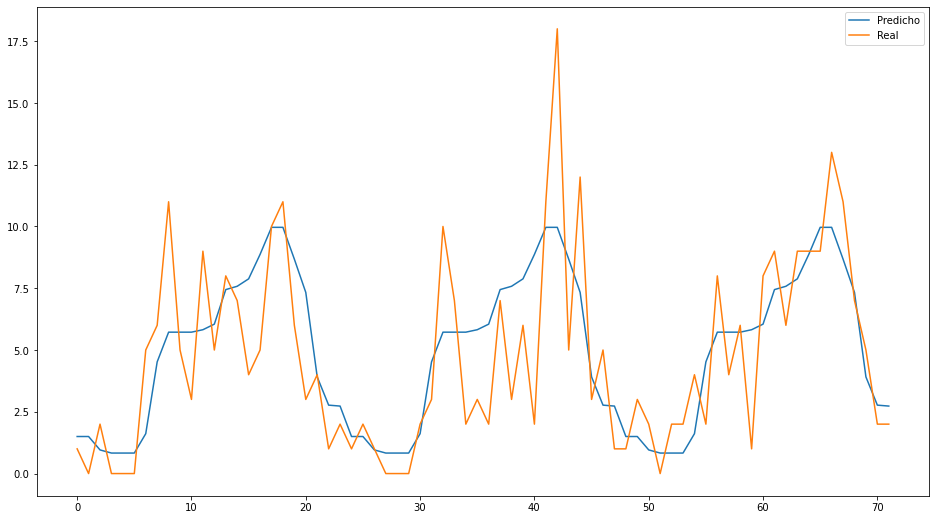

In [133]:
#Viajes salientes en fin de semana 
X = df.loc[df.mes<=11][['mes','fin_de_semana','hora']]
y = df.loc[df.mes<=11][['viajes_salientes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

gb_tr_sf.fit(X_train, y_train)
y_pred = gb_tr_sf.predict(X_test)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
print(y_pred.shape)

#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

Test error (mse): 8.855705984086196
(720,)


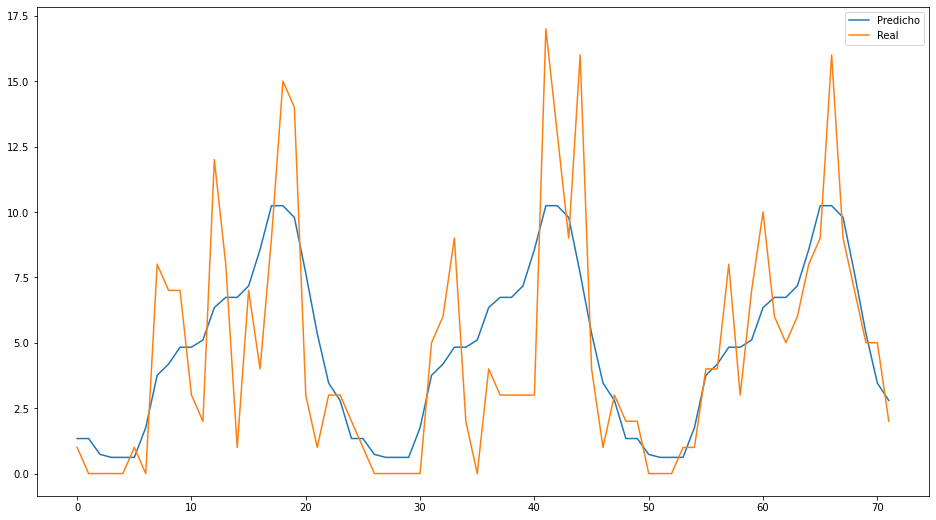

In [134]:
#Viajes entrantes en fin de semana
X = df.loc[df.mes<=11][['mes','fin_de_semana','hora']]
y = df.loc[df.mes<=11][['viajes_entrantes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

gb_tr_ef.fit(X_train, y_train)
y_pred = gb_tr_ef.predict(X_test)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
#print(y_pred)
print(y_pred.shape)

#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

Test error (mse): 9.392345021916276
(720,)


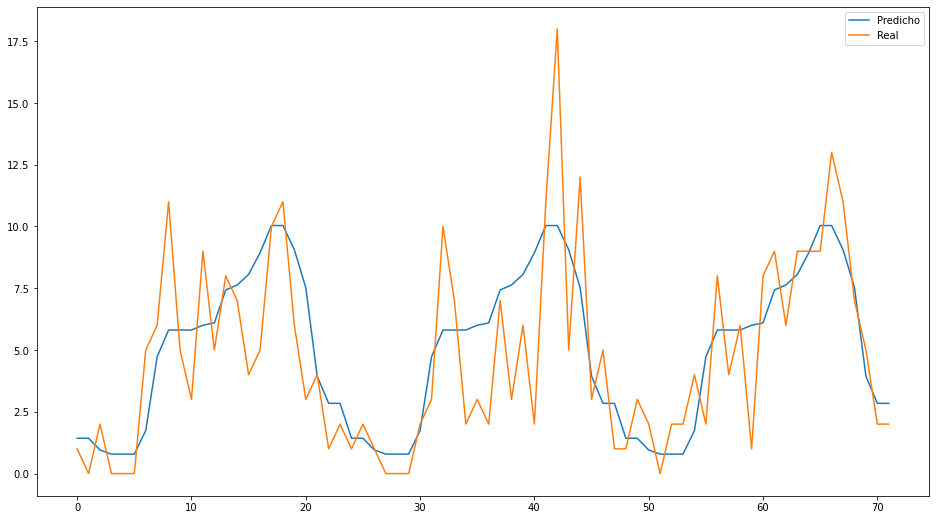

In [135]:
#Viajes salientes entre semana

X = df.loc[df.mes<=11][['mes','día_en_semana','hora']]
y = df.loc[df.mes<=11][['viajes_salientes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]
gb_tr_ss.fit(X_train, y_train)
y_pred = gb_tr_ss.predict(X_test)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
print(y_pred.shape)

#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

Test error (mse): 9.11199515194238
(720,)


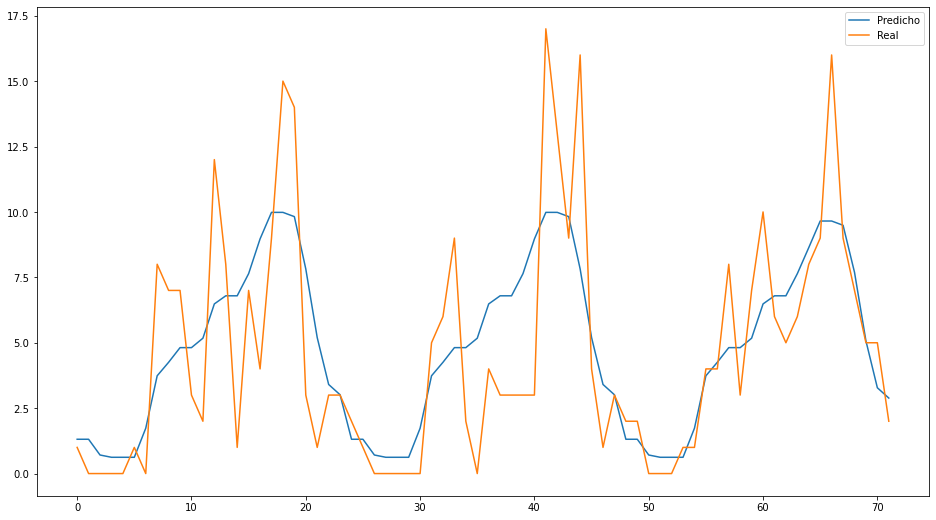

In [136]:
#Viajes entrantes entre semana 

X = df.loc[df.mes<=11][['mes','día_en_semana','hora']]
y = df.loc[df.mes<=11][['viajes_entrantes']]

steps = 24*30
X_train = X[:-steps]
X_test  = X[-steps:]
y_train = y[:-steps]
y_test  = y[-steps:]

gb_tr_es.fit(X_train, y_train)
y_pred = gb_tr_es.predict(X_test)
error_mse = mean_squared_error(y_test.values, y_pred )
print(f"Test error (mse): {error_mse}")
print(y_pred.shape)

#Visualizamos 3 dias de predicciones 
plt.figure(figsize=(16, 9))
plt.plot(y_pred[:72], label = 'Predicho')
plt.plot(y_test.values[:72], label = 'Real')

plt.legend()
plt.show()

# Estimacion en tiempo real 

In [137]:
from datetime import datetime
import json
import requests

In [138]:
url = 'https://baecobici.herokuapp.com/api/disponibilidad/'
contenido = requests.get(url).text
objeto = json.loads(contenido)

In [140]:
for i in range(len(objeto)):
    
    if [*objeto.keys()][i] == '14':
    
        ecobicis = [*objeto.values()][i]['num_bikes_available']
        año = int([*objeto.values()][i]['last_reported'][:4])
        mes = int([*objeto.values()][i]['last_reported'][4:6])
        día = int([*objeto.values()][i]['last_reported'][6:8])
        hora = int([*objeto.values()][i]['last_reported'][8:10])
        día_en_semana = int(datetime(int(año), int(mes), int(día)).weekday())
        if día_en_semana > 4:
            fin_de_semana = 1
        else:
            fin_de_semana = 0
            
print(año,mes,día,hora,día_en_semana,fin_de_semana)

2022 3 10 14 3 0


In [160]:
def estimación_viajes_salientes(df,mes,día_en_semana,hora):

	X = df.loc[df.mes<12][['mes','día_en_semana','hora']]
	y = df.loc[df.mes<12][['viajes_salientes']]

	steps = 24
	X_train = X[:-steps]
	X_test  = X[-steps:]
	y_train = y[:-steps]
	y_test  = y[-steps:]

	gb_tr_ss.fit(X_train, y_train)
	y_pred_tr = gb_tr_ss.predict(X_test)
	gb_tr_ss.predict([[mes,día_en_semana,hora]])
    
	return(int(y_pred_tr[hora]))

In [161]:
def estimación_viajes_entrantes(df,mes,día_en_semana,hora):

	X = df.loc[df.mes<12][['mes','día_en_semana','hora']]
	y = df.loc[df.mes<12][['viajes_entrantes']]

	steps = 24
	X_train = X[:-steps]
	X_test  = X[-steps:]
	y_train = y[:-steps]
	y_test  = y[-steps:]

	gb_tr_es.fit(X_train, y_train)
	y_pred_tr = gb_tr_es.predict(X_test)
	gb_tr_es.predict([[mes,día_en_semana,hora]])

	return(int(y_pred_tr[hora]))

In [162]:
viajes_entrantes = estimación_viajes_entrantes(df,mes,día_en_semana,hora)
viajes_salientes = estimación_viajes_salientes(df,mes,día_en_semana,hora)

In [163]:
print("La disponibilidad de ecobicis a este mismo momento es de:", ecobicis)
print("El flujo saliente de ecobicis en la próxima hora va a ser de:", viajes_salientes)
print("El flujo entrante de ecobicis en la próxima hora va a ser de:", viajes_entrantes)
print("La disponibilidad de ecobicis en una hora va a ser de:", ecobicis-viajes_salientes+viajes_entrantes)

La disponibilidad de ecobicis a este mismo momento es de: 16
El flujo saliente de ecobicis en la próxima hora va a ser de: 7
El flujo entrante de ecobicis en la próxima hora va a ser de: 6
La disponibilidad de ecobicis en una hora va a ser de: 15
